The notebook is used for network analysis and exploration of labels with the image-labels data we processed with AWS Rekognition. The raw data is the social media (X, formerly Twitter) posts that mention #MWC24 (2024 Mobile World Congress) containing images from the NodeXL Graph Gallery from our client. We intend to identify representative images from a total of 3000+ images.

In [ ]:
import pandas as pd
import networkx as nx
from itertools import combinations
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Capstone Project/NodeXL_tweets_labels.csv'
df=pd.read_csv(file_path)

In [ ]:
df.head()

,Unnamed: 0,Confidence Threshold,Labels,Image Name,Image URL,Media in Tweet,Media Type,Tweet URL
0,0,False,['Blackboard'],FQPvyP0XsBYT0_e.jpg,https://pbs.twimg.com/media/FQPvyP0XsBYT0_e.jpg,https://t.co/WpzDllqKhf https://pbs.twimg.com/...,photo,https://t.co/WpzDllqKhf
1,1,False,"['Outdoors', 'Cross', 'Nature']",FpQm4VQXwAEh29s.jpg,https://pbs.twimg.com/media/FpQm4VQXwAEh29s.jpg,https://t.co/lu3TqALtrs https://pbs.twimg.com/...,photo,https://t.co/lu3TqALtrs
2,2,True,"['Adult', 'Male', 'Man', 'Person', 'Clothing',...",FpsDtlRXwAIkgL4.jpg,https://pbs.twimg.com/media/FpsDtlRXwAIkgL4.jpg,https://t.co/xSfLH7zAdn https://pbs.twimg.com/...,photo,https://t.co/xSfLH7zAdn
3,3,False,"['Advertisement', 'Astronomy', 'Outer Space']",GD30009W8AASCYQ.jpg,https://pbs.twimg.com/media/GD30009W8AASCYQ.jpg,https://t.co/7mBSR5nCmW https://pbs.twimg.com/...,photo,https://t.co/7mBSR5nCmW
4,4,True,"['City', 'Urban', 'Metropolis', 'Architecture'...",GDVdH1qX0AMv1Wd.jpg,https://pbs.twimg.com/media/GDVdH1qX0AMv1Wd.jpg,https://t.co/KgWWt5rA4V https://pbs.twimg.com/...,photo,https://t.co/KgWWt5rA4V


In [ ]:
image_labels_dict = pd.Series(df['Labels'].values, index=df['Image Name']).to_dict()

print(image_labels_dict)

{'FQPvyP0XsBYT0_e.jpg': "['Blackboard']", 'FpQm4VQXwAEh29s.jpg': "['Outdoors', 'Cross', 'Nature']", 'FpsDtlRXwAIkgL4.jpg': "['Adult', 'Male', 'Man', 'Person', 'Clothing', 'Formal Wear', 'Suit', 'Text', 'Face', 'Head']", 'GD30009W8AASCYQ.jpg': "['Advertisement', 'Astronomy', 'Outer Space']", 'GDVdH1qX0AMv1Wd.jpg': "['City', 'Urban', 'Metropolis', 'Architecture', 'Building', 'Cityscape', 'Person', 'Car', 'Transportation', 'Vehicle', 'Road', 'Street']", 'GE2xusBWQAEA4Ma.jpg': "['Electronics', 'Mobile Phone', 'Phone']", 'GE9Unm-XsAAnroJ.jpg': "['Page', 'Text', 'Person']", 'GEDVEOZXMAAVxGk.jpg': "['Adult', 'Female', 'Person', 'Woman', 'Advertisement', 'Face', 'Head']", 'GEmf-NkXwAAJXsX.jpg': "['Advertisement', 'Poster']", 'GEnpqGwWQAAtRJc.jpg': "['City', 'Urban']", 'GEr6ev-WQAAsnCH.jpg': "['People', 'Person', 'Adult', 'Male', 'Man', 'Face', 'Head', 'Advertisement', 'Poster', 'Crowd']", 'GExkDqSWsAAhqnn.jpg': "['Shop', 'Shopping Mall', 'People', 'Person', 'City', 'Architecture', 'Building', 

Make a small piece of sample data to test.

In [ ]:
from itertools import islice

sample_image_labels_dict = dict(islice(image_labels_dict.items(), 100))
sample_image_labels_dict

{'FQPvyP0XsBYT0_e.jpg': "['Blackboard']",
 'FpQm4VQXwAEh29s.jpg': "['Outdoors', 'Cross', 'Nature']",
 'FpsDtlRXwAIkgL4.jpg': "['Adult', 'Male', 'Man', 'Person', 'Clothing', 'Formal Wear', 'Suit', 'Text', 'Face', 'Head']",
 'GD30009W8AASCYQ.jpg': "['Advertisement', 'Astronomy', 'Outer Space']",
 'GDVdH1qX0AMv1Wd.jpg': "['City', 'Urban', 'Metropolis', 'Architecture', 'Building', 'Cityscape', 'Person', 'Car', 'Transportation', 'Vehicle', 'Road', 'Street']",
 'GE2xusBWQAEA4Ma.jpg': "['Electronics', 'Mobile Phone', 'Phone']",
 'GE9Unm-XsAAnroJ.jpg': "['Page', 'Text', 'Person']",
 'GEDVEOZXMAAVxGk.jpg': "['Adult', 'Female', 'Person', 'Woman', 'Advertisement', 'Face', 'Head']",
 'GEmf-NkXwAAJXsX.jpg': "['Advertisement', 'Poster']",
 'GEnpqGwWQAAtRJc.jpg': "['City', 'Urban']",
 'GEr6ev-WQAAsnCH.jpg': "['People', 'Person', 'Adult', 'Male', 'Man', 'Face', 'Head', 'Advertisement', 'Poster', 'Crowd']",
 'GExkDqSWsAAhqnn.jpg': "['Shop', 'Shopping Mall', 'People', 'Person', 'City', 'Architecture', '

Perform network analysis on sample data by connecting all nodes and with similarity score as weights

Edges and their similarity scores:
('FQPvyP0XsBYT0_e.jpg', 'FpQm4VQXwAEh29s.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'FpsDtlRXwAIkgL4.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GD30009W8AASCYQ.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GDVdH1qX0AMv1Wd.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GE2xusBWQAEA4Ma.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GE9Unm-XsAAnroJ.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GEDVEOZXMAAVxGk.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GEmf-NkXwAAJXsX.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GEnpqGwWQAAtRJc.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GEr6ev-WQAAsnCH.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GExkDqSWsAAhqnn.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GF1H4_KWEAAHG6h.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GF4fxe5XUAAqRND.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GF4qWWWXYAA6C05.jpg', {'weight': 0.0})
('FQPvyP0XsBYT0_e.jpg', 'GF5-IOmXQAAGk7I.jpg', {'weight': 0.0})
('FQP

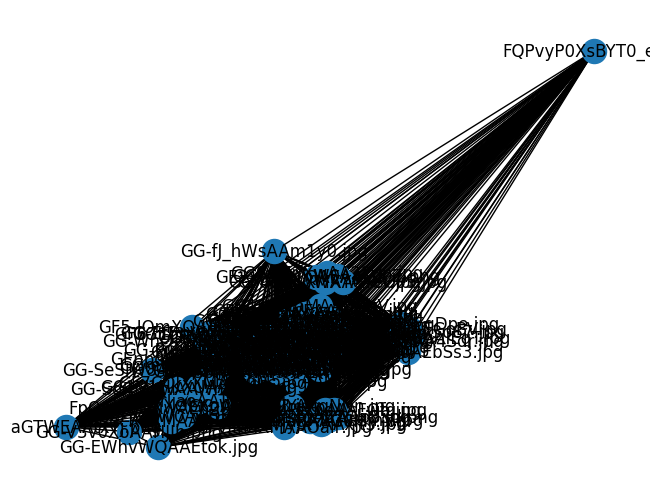

In [ ]:
G = nx.Graph()

for image in sample_image_labels_dict.keys():
    G.add_node(image)

# calculate similarity scores and add edges
for image in sample_image_labels_dict:
  sample_image_labels_dict[image] = eval(sample_image_labels_dict[image])

for image1, image2 in combinations(sample_image_labels_dict.keys(), 2):
    common_interests = len(set(sample_image_labels_dict[image1]) & set(sample_image_labels_dict[image2]))
    similarity_score = common_interests / len(sample_image_labels_dict[image1] + sample_image_labels_dict[image2])
    G.add_edge(image1, image2, weight=similarity_score)

# edges and weights
print("Edges and their similarity scores:")
for edge in G.edges(data=True):
    print(edge)

nx.draw(G, with_labels=True)

In [ ]:
# calculate centralities for sample data
sample_eigenvector_centrality = nx.eigenvector_centrality(G)
sample_degree_centrality = nx.degree_centrality(G)
sample_closeness_centrality = nx.closeness_centrality(G)
sample_betweenness_centrality = nx.betweenness_centrality(G)

In [ ]:
sample_eigenvector_centrality

{'FQPvyP0XsBYT0_e.jpg': 0.1,
 'FpQm4VQXwAEh29s.jpg': 0.1,
 'FpsDtlRXwAIkgL4.jpg': 0.1,
 'GD30009W8AASCYQ.jpg': 0.1,
 'GDVdH1qX0AMv1Wd.jpg': 0.1,
 'GE2xusBWQAEA4Ma.jpg': 0.1,
 'GE9Unm-XsAAnroJ.jpg': 0.1,
 'GEDVEOZXMAAVxGk.jpg': 0.1,
 'GEmf-NkXwAAJXsX.jpg': 0.1,
 'GEnpqGwWQAAtRJc.jpg': 0.1,
 'GEr6ev-WQAAsnCH.jpg': 0.1,
 'GExkDqSWsAAhqnn.jpg': 0.1,
 'GF1H4_KWEAAHG6h.jpg': 0.1,
 'GF4fxe5XUAAqRND.jpg': 0.1,
 'GF4qWWWXYAA6C05.jpg': 0.1,
 'GF5-IOmXQAAGk7I.jpg': 0.1,
 'GF6-ZssXcAA12xE.jpg': 0.1,
 'GF67t73XQAA31GJ.jpg': 0.1,
 'GF68ucMX0AAK0Uq.jpg': 0.1,
 'GF6_suxWMAEPgX_.jpg': 0.1,
 'GF7AdgIWcAAM73a.jpg': 0.1,
 'GF7BRHbW8AAFtv4.jpg': 0.1,
 'GF7COJXXMAAtu0s.jpg': 0.1,
 'GFFQrnuagAAG0My.jpg': 0.1,
 'GFKdqM5acAAN9lr.jpg': 0.1,
 'GFPX1NQWwAASD2f.png': 0.1,
 'GFQvbogXUAAEqMw.jpg': 0.1,
 'GFRbCgbXcAAEqTK.jpg': 0.1,
 'GFTkhPSbYAAVMFm.jpg': 0.1,
 'GFlO62yWgAAjS1v.jpg': 0.1,
 'GFovaGTWEAAtxTj.png': 0.1,
 'GFqY0jiXMAA1NwG.jpg': 0.1,
 'GFuQhK_WYAA5kqQ.jpg': 0.1,
 'GFumXQbXgAAEwN3.jpg': 0.1,
 'GFvJIhhXMAAO

The problem for a fully connected network is that its nodes have uniform values in a centrality measure. (as seen above)

So for this graph, I calculate the total similarity score for each node and assume that the node with the largest total similarity score is the most salient node for the sample data.

In [ ]:
total_similarity_scores = {node: 0 for node in G.nodes()}
for node1, node2, weight in G.edges(data=True):
    total_similarity_scores[node1] += weight['weight']
    total_similarity_scores[node2] += weight['weight']

In [ ]:
total_similarity_scores

{'FQPvyP0XsBYT0_e.jpg': 0.0,
 'FpQm4VQXwAEh29s.jpg': 1.5936507936507933,
 'FpsDtlRXwAIkgL4.jpg': 7.528336670022966,
 'GD30009W8AASCYQ.jpg': 4.197149500825971,
 'GDVdH1qX0AMv1Wd.jpg': 4.614531587640106,
 'GE2xusBWQAEA4Ma.jpg': 2.3206349206349204,
 'GE9Unm-XsAAnroJ.jpg': 6.675743129419601,
 'GEDVEOZXMAAVxGk.jpg': 8.997746061987545,
 'GEmf-NkXwAAJXsX.jpg': 8.560890863522442,
 'GEnpqGwWQAAtRJc.jpg': 2.4365079365079363,
 'GEr6ev-WQAAsnCH.jpg': 10.468707367250236,
 'GExkDqSWsAAhqnn.jpg': 5.493479004655475,
 'GF1H4_KWEAAHG6h.jpg': 4.868207370159703,
 'GF4fxe5XUAAqRND.jpg': 5.20797337038756,
 'GF4qWWWXYAA6C05.jpg': 1.5646076146076147,
 'GF5-IOmXQAAGk7I.jpg': 0.8857142857142857,
 'GF6-ZssXcAA12xE.jpg': 6.432390893420306,
 'GF67t73XQAA31GJ.jpg': 2.517460317460318,
 'GF68ucMX0AAK0Uq.jpg': 7.270498873394345,
 'GF6_suxWMAEPgX_.jpg': 5.645383897148602,
 'GF7AdgIWcAAM73a.jpg': 7.319656405685818,
 'GF7BRHbW8AAFtv4.jpg': 6.593444227622728,
 'GF7COJXXMAAtu0s.jpg': 2.5901154401154405,
 'GFFQrnuagAAG0My.j

In [ ]:
most_salient_node = max(total_similarity_scores, key=total_similarity_scores.get)

In [ ]:
print(f"Sample's most salient node based on total similarity scores with others is: {most_salient_node}")

Sample's most salient node based on total similarity scores with others is: GG-SB8RXkAASbir.jpg


In [ ]:
most_salient_image_urls = df.loc[(df['Image Name'] == most_salient_node)]['Image URL']
most_salient_image_urls

49    https://pbs.twimg.com/media/GG-SB8RXkAASbir.jpg
Name: Image URL, dtype: object

In [ ]:
most_salient_image_labels = df.loc[(df['Image Name'] == most_salient_node)]['Labels']
most_salient_image_labels

49    ['Advertisement', 'Poster', 'Person', 'Face', ...
Name: Labels, dtype: object

In [ ]:
# sort and get the top 5 nodes
sorted_nodes = sorted(total_similarity_scores, key=total_similarity_scores.get, reverse=True)

top_5_most_salient_nodes = sorted_nodes[:5]

print(f"The top 5 most salient nodes based on total similarity score with others are: {top_5_most_salient_nodes}")


The top 5 most salient nodes based on total similarity score with others are: ['GG-SB8RXkAASbir.jpg', 'GFPX1NQWwAASD2f.png', 'GG-fyOHWMAAsDW-.jpg', 'GEr6ev-WQAAsnCH.jpg', 'GG0c5iJaMAANUW2.jpg']


In [ ]:
# check the top 5 image urls
for nodes in top_5_most_salient_nodes:
  print(df.loc[(df['Image Name'] == nodes)]['Image URL'])

49    https://pbs.twimg.com/media/GG-SB8RXkAASbir.jpg
Name: Image URL, dtype: object
25    https://pbs.twimg.com/media/GFPX1NQWwAASD2f.png
Name: Image URL, dtype: object
60    https://pbs.twimg.com/media/GG-fyOHWMAAsDW-.jpg
Name: Image URL, dtype: object
10    https://pbs.twimg.com/media/GEr6ev-WQAAsnCH.jpg
Name: Image URL, dtype: object
74    https://pbs.twimg.com/media/GG0c5iJaMAANUW2.jpg
Name: Image URL, dtype: object


In [ ]:
# check the top 5 image labels
for nodes in top_5_most_salient_nodes:
  print(df.loc[(df['Image Name'] == nodes)]['Labels'])

49    ['Advertisement', 'Poster', 'Person', 'Face', ...
Name: Labels, dtype: object
25    ['Advertisement', 'Poster', 'Person']
Name: Labels, dtype: object
60    ['Advertisement', 'Poster', 'Adult', 'Male', '...
Name: Labels, dtype: object
10    ['People', 'Person', 'Adult', 'Male', 'Man', '...
Name: Labels, dtype: object
74    ['People', 'Person', 'Advertisement', 'Poster'...
Name: Labels, dtype: object


## The second network analysis
I make a graph different from the first network analysis approach. I create nodes with images and edges based on the presence of any shared label between image pairs. The weight is the count of shared labels. This approach can prevent from creating of fully connected networks and also avoid creating a network with uniform values for a centrality measure. However, the same challenge remains - the time and computational power needed to process a great amount of images is a lot. For example, it takes over 49 minutes to process a network of a total of 3000+ images.

In [ ]:
# test based on sample data of 100 images
start_time = time.time()

G = nx.Graph()

G.add_nodes_from(df['Image Name'])


# add edges and weights when two images have shared labels
for image1, image2 in combinations(sample_image_labels_dict.keys(), 2):
  shared_labels = set(sample_image_labels_dict[image1]) & set(sample_image_labels_dict[image2])

  if shared_labels:
    weight = len(shared_labels)
    G.add_edge(image1, image2, weight=weight)

# calculate centralities
sample_eigenvector_centrality = nx.eigenvector_centrality(G)
sample_degree_centrality = nx.degree_centrality(G)
sample_closeness_centrality = nx.closeness_centrality(G)
sample_betweenness_centrality = nx.betweenness_centrality(G)

# find the node (image) with the highest centralities
sample_eigenvector_central_image = max(sample_eigenvector_centrality, key=sample_eigenvector_centrality.get)
sample_degree_central_image = max(sample_degree_centrality, key=sample_degree_centrality.get)
sample_closeness_central_image = max(sample_closeness_centrality, key=sample_closeness_centrality.get)
sample_betweenness_central_image = max(sample_betweenness_centrality, key=sample_betweenness_centrality.get)


end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken to process network analysis for 100 image: {total_time} seconds")

Total time taken to process network analysis for 100 image: 11.944365739822388 seconds


In [ ]:
print(f"The most central image of sample data based on eigenvector centrality is: {sample_eigenvector_central_image}")
print(f"The most central image of sample data based on degree centrality is: {sample_degree_central_image}")
print(f"The most central image of sample data based on closeness centrality is: {sample_closeness_central_image}")
print(f"The most central image of sample data based on betweenness centrality is: {sample_betweenness_central_image}")

The most central image of sample data based on eigenvector centrality is: GFlO62yWgAAjS1v.jpg
The most central image of sample data based on degree centrality is: GFlO62yWgAAjS1v.jpg
The most central image of sample data based on closeness centrality is: GFlO62yWgAAjS1v.jpg
The most central image of sample data based on betweenness centrality is: GFKdqM5acAAN9lr.jpg


In [ ]:
print(f"The most central image url of sample data based on eigenvector centrality is: {df.loc[(df['Image Name'] == sample_eigenvector_central_image)]['Image URL']}")
print(f"The most central image url of sample data based on degree centrality is: {df.loc[(df['Image Name'] == sample_degree_central_image)]['Image URL']}")
print(f"The most central image url of sample data based on closeness centrality is: {df.loc[(df['Image Name'] == sample_closeness_central_image)]['Image URL']}")
print(f"The most central image url of sample data based on betweenness centrality is: {df.loc[(df['Image Name'] == sample_betweenness_central_image)]['Image URL']}")

The most central image url of sample data based on eigenvector centrality is: 29    https://pbs.twimg.com/media/GFlO62yWgAAjS1v.jpg
Name: Image URL, dtype: object
The most central image url of sample data based on degree centrality is: 29    https://pbs.twimg.com/media/GFlO62yWgAAjS1v.jpg
Name: Image URL, dtype: object
The most central image url of sample data based on closeness centrality is: 29    https://pbs.twimg.com/media/GFlO62yWgAAjS1v.jpg
Name: Image URL, dtype: object
The most central image url of sample data based on betweenness centrality is: 24    https://pbs.twimg.com/media/GFKdqM5acAAN9lr.jpg
Name: Image URL, dtype: object


In [ ]:
# build a network based on total data of 3000+ images
start_time = time.time()

G = nx.Graph()

G.add_nodes_from(df['Image Name'])

# add edges and weights when two images have shared labels
for image in image_labels_dict:
  image_labels_dict[image] = eval(image_labels_dict[image])

for image1, image2 in combinations(image_labels_dict.keys(), 2):
  shared_labels = set(image_labels_dict[image1]) & set(image_labels_dict[image2])

  if shared_labels:
    weight = len(shared_labels)
    G.add_edge(image1, image2, weight=weight)

# calculate Centralities
eigenvector_centrality = nx.eigenvector_centrality(G)
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# find the node (image) with the highest centralities
eigenvector_central_image = max(eigenvector_centrality, key=eigenvector_centrality.get)
degree_central_image = max(degree_centrality, key=degree_centrality.get)
closeness_central_image = max(closeness_centrality, key=closeness_centrality.get)
betweenness_central_image = max(betweenness_centrality, key=betweenness_centrality.get)


end_time = time.time()
total_time = end_time - start_time
dict_length = len(image_labels_dict)

print(f"Total time taken to process network analysis for {dict_length} image: {total_time} seconds")

Total time taken to process network analysis for 3178 image: 2936.4091641902924 seconds


In [ ]:
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Total time taken to process {dict_length} images: {int(hours)} hours {int(minutes)} minutes {seconds} seconds")

Total time taken to process 3178 images: 0 hours 48 minutes 56.40916419029236 seconds


In [ ]:
print(f"The most central image based on eigenvector centrality is: {eigenvector_central_image}")
print(f"The most central image based on degree centrality is: {degree_central_image}")
print(f"The most central image based on closeness centrality is: {closeness_central_image}")
print(f"The most central image based on betweenness centrality is: {betweenness_central_image}")

The most central image based on eigenvector centrality is: GHSrqsHaAAA2PPx.jpg
The most central image based on degree centrality is: GGyDSU3XEAAiGwU.jpg
The most central image based on closeness centrality is: GGyDSU3XEAAiGwU.jpg
The most central image based on betweenness centrality is: GGyHmviXwAAQ__l.jpg


In [ ]:
print(f"The most central image url based on eigenvector centrality is: {df.loc[(df['Image Name'] == eigenvector_central_image)]['Image URL']}")
print(f"The most central image url based on degree centrality is: {df.loc[(df['Image Name'] == degree_central_image)]['Image URL']}")
print(f"The most central image url based on closeness centrality is: {df.loc[(df['Image Name'] == closeness_central_image)]['Image URL']}")
print(f"The most central image url based on betweenness centrality is: {df.loc[(df['Image Name'] == betweenness_central_image)]['Image URL']}")

The most central image url based on eigenvector centrality is: 3155    https://pbs.twimg.com/media/GHSrqsHaAAA2PPx.jpg
Name: Image URL, dtype: object
The most central image url based on degree centrality is: 892    https://pbs.twimg.com/media/GGyDSU3XEAAiGwU.jpg
Name: Image URL, dtype: object
The most central image url based on closeness centrality is: 892    https://pbs.twimg.com/media/GGyDSU3XEAAiGwU.jpg
Name: Image URL, dtype: object
The most central image url based on betweenness centrality is: 898    https://pbs.twimg.com/media/GGyHmviXwAAQ__l.jpg
Name: Image URL, dtype: object


In [ ]:
print(f"The most central image labels based on eigenvector centrality is: {df.loc[df['Image Name'] == eigenvector_central_image]['Labels']}")
print(f"The most central image labels based on degree centrality is: {df.loc[(df['Image Name'] == degree_central_image)]['Labels']}")
print(f"The most central image labels based on closeness centrality is: {df.loc[(df['Image Name'] == closeness_central_image)]['Labels']}")
print(f"The most central image labels based on betweenness centrality is: {df.loc[(df['Image Name'] == betweenness_central_image)]['Labels']}")

The most central image labels based on eigenvector centrality is: 3155    ['Advertisement', 'Poster', 'Person', 'Compute...
Name: Labels, dtype: object
The most central image labels based on degree centrality is: 892    ['Advertisement', 'Adult', 'Female', 'Person',...
Name: Labels, dtype: object
The most central image labels based on closeness centrality is: 892    ['Advertisement', 'Adult', 'Female', 'Person',...
Name: Labels, dtype: object
The most central image labels based on betweenness centrality is: 898    ['Person', 'Logo', 'Art', 'Graphics', 'Face', ...
Name: Labels, dtype: object


## Exploration of potential uses of labels (Belongs to Appendix section in the report)
### Frequency-based approach:  
To brainstorm the potential uses of the labels (and to mitigate the risk of limited computational power and time to process network analysis for too many images), I explore a few ways to find the most representative images with labels. First, I assume that images with more commonly shared labels to be more central in a network, and I use the frequency of labels to infer the most representative images.

In [ ]:
# flatten all labels into a single list to count occurrences
all_labels = [label for labels in image_labels_dict.values() for label in labels]

print(all_labels)

['Blackboard', 'Outdoors', 'Cross', 'Nature', 'Adult', 'Male', 'Man', 'Person', 'Clothing', 'Formal Wear', 'Suit', 'Text', 'Face', 'Head', 'Advertisement', 'Astronomy', 'Outer Space', 'City', 'Urban', 'Metropolis', 'Architecture', 'Building', 'Cityscape', 'Person', 'Car', 'Transportation', 'Vehicle', 'Road', 'Street', 'Electronics', 'Mobile Phone', 'Phone', 'Page', 'Text', 'Person', 'Adult', 'Female', 'Person', 'Woman', 'Advertisement', 'Face', 'Head', 'Advertisement', 'Poster', 'City', 'Urban', 'People', 'Person', 'Adult', 'Male', 'Man', 'Face', 'Head', 'Advertisement', 'Poster', 'Crowd', 'Shop', 'Shopping Mall', 'People', 'Person', 'City', 'Architecture', 'Building', 'Convention Center', 'Photography', 'Person', 'Camera', 'Electronics', 'Advertisement', 'Poster', 'Couch', 'Furniture', 'Indoors', 'Interior Design', 'Computer', 'Electronics', 'Laptop', 'Pc', 'Computer Hardware', 'Hardware', 'Church', 'Cathedral', 'Landmark', 'Adult', 'Man', 'Person', 'Architecture', 'Building', 'Head',

In [ ]:
from collections import Counter

# count the occurence of each label across all images, and get the sub-score for each label
label_occurrences = Counter(all_labels)
label_occurrences

Counter({'Blackboard': 9,
         'Outdoors': 189,
         'Cross': 2,
         'Nature': 141,
         'Adult': 880,
         'Male': 717,
         'Man': 726,
         'Person': 1691,
         'Clothing': 445,
         'Formal Wear': 189,
         'Suit': 167,
         'Text': 389,
         'Face': 428,
         'Head': 440,
         'Advertisement': 703,
         'Astronomy': 22,
         'Outer Space': 16,
         'City': 223,
         'Urban': 204,
         'Metropolis': 41,
         'Architecture': 356,
         'Building': 353,
         'Cityscape': 43,
         'Car': 43,
         'Transportation': 82,
         'Vehicle': 83,
         'Road': 41,
         'Street': 25,
         'Electronics': 524,
         'Mobile Phone': 144,
         'Phone': 154,
         'Page': 58,
         'Female': 288,
         'Woman': 291,
         'Poster': 554,
         'People': 565,
         'Crowd': 347,
         'Shop': 23,
         'Shopping Mall': 16,
         'Convention Center': 19,
     

In [ ]:
# calculate a score for each image based on the sum of its labels' sub-scores

def image_score(dictionary):
  image_score = {}
  for image, labels in dictionary.items():
    total_score = 0
    for label in labels:
      total_score += label_occurrences[label]
    image_score[image] = total_score

  return image_score

In [ ]:
frequency_image_score = image_score(image_labels_dict)
frequency_image_score

{'FQPvyP0XsBYT0_e.jpg': 9,
 'FpQm4VQXwAEh29s.jpg': 332,
 'FpsDtlRXwAIkgL4.jpg': 6072,
 'GD30009W8AASCYQ.jpg': 741,
 'GDVdH1qX0AMv1Wd.jpg': 3185,
 'GE2xusBWQAEA4Ma.jpg': 822,
 'GE9Unm-XsAAnroJ.jpg': 2138,
 'GEDVEOZXMAAVxGk.jpg': 4721,
 'GEmf-NkXwAAJXsX.jpg': 1257,
 'GEnpqGwWQAAtRJc.jpg': 427,
 'GEr6ev-WQAAsnCH.jpg': 7051,
 'GExkDqSWsAAhqnn.jpg': 3246,
 'GF1H4_KWEAAHG6h.jpg': 2420,
 'GF4fxe5XUAAqRND.jpg': 1508,
 'GF4qWWWXYAA6C05.jpg': 1200,
 'GF5-IOmXQAAGk7I.jpg': 67,
 'GF6-ZssXcAA12xE.jpg': 3297,
 'GF67t73XQAA31GJ.jpg': 709,
 'GF68ucMX0AAK0Uq.jpg': 3381,
 'GF6_suxWMAEPgX_.jpg': 2984,
 'GF7AdgIWcAAM73a.jpg': 2559,
 'GF7BRHbW8AAFtv4.jpg': 2560,
 'GF7COJXXMAAtu0s.jpg': 461,
 'GFFQrnuagAAG0My.jpg': 421,
 'GFKdqM5acAAN9lr.jpg': 1678,
 'GFPX1NQWwAASD2f.png': 2948,
 'GFQvbogXUAAEqMw.jpg': 1257,
 'GFRbCgbXcAAEqTK.jpg': 1691,
 'GFTkhPSbYAAVMFm.jpg': 1257,
 'GFlO62yWgAAjS1v.jpg': 5200,
 'GFovaGTWEAAtxTj.png': 43,
 'GFqY0jiXMAA1NwG.jpg': 3571,
 'GFuQhK_WYAA5kqQ.jpg': 2559,
 'GFumXQbXgAAEwN3.jpg': 

In [ ]:
# find the top 3 image with the highest score based on label frequency
frequency_top10_image = sorted(frequency_image_score, key=frequency_image_score.get, reverse = True)[:10]

print(f"Top 10 most salient image based on label occurrences is: {frequency_top10_image}")


Top 10 most salient image based on label occurrences is: ['GHROwD7XwAAu1em.jpg', 'GHQVUIQWMAAmsZ2.jpg', 'GHRf0pvWYAA875m.jpg', 'GHFR4EZWoAAh_-w.jpg', 'GHQHTjmXIAAEe4A.jpg', 'GHFimXqXUAEZBaH.jpg', 'GGu1UgtWMAAb9cy.jpg', 'GHQck3FXkAA0Lra.jpg', 'GHRb-4ZWwAAf9Aq.jpg', 'GHSCM4CbEAA0hui.jpg']


In [ ]:
def top10_image_urls(dataframe, top10_image):
    top10_image_urls = dataframe.loc[dataframe['Image Name'].isin(top10_image)]['Image URL']
    return top10_image_urls

frequency_top10_image_urls = top10_image_urls(df, frequency_top10_image)
frequency_top10_image_urls

758     https://pbs.twimg.com/media/GGu1UgtWMAAb9cy.jpg
1299    https://pbs.twimg.com/media/GHFR4EZWoAAh_-w.jpg
1316    https://pbs.twimg.com/media/GHFimXqXUAEZBaH.jpg
2253    https://pbs.twimg.com/media/GHQHTjmXIAAEe4A.jpg
2378    https://pbs.twimg.com/media/GHQVUIQWMAAmsZ2.jpg
2442    https://pbs.twimg.com/media/GHQck3FXkAA0Lra.jpg
2784    https://pbs.twimg.com/media/GHROwD7XwAAu1em.jpg
2860    https://pbs.twimg.com/media/GHRb-4ZWwAAf9Aq.jpg
2887    https://pbs.twimg.com/media/GHRf0pvWYAA875m.jpg
3039    https://pbs.twimg.com/media/GHSCM4CbEAA0hui.jpg
Name: Image URL, dtype: object

We see that the top 10 images mostly contain 'Male','People'... I suspect that the common labels overly dominate our dataset and therefore skew the results towards these common labels. It may potentially obscure more uniquely representative images, so we need to consider other strategies.

### Weighting by Inverse Frequency
I adjust the scores for each image by considering the inverse frequency of each label. This approach decreases the importance of overly common labels and increases the significance of rarer ones, similar to the TF-IDF (Term Frequency-Inverse Document Frequency) approach used in text analysis.

First, I try to perform a simplified adaptation

In [ ]:
len(image_labels_dict)

3178

In [ ]:
# calculate inverse frequency for each label
total_images = len(image_labels_dict)

label_inverse_frequency = {label: total_images / occurrence for label, occurrence in label_occurrences.items()}

In [ ]:
sorted(label_inverse_frequency.items(), key=lambda item: item[1], reverse=True)

[('Sad', 3178.0),
 ('Driving License', 3178.0),
 ('Letter', 3178.0),
 ('Panoramic', 3178.0),
 ('Ping Pong Paddle', 3178.0),
 ('Sliding Door', 3178.0),
 ('Corner', 3178.0),
 ('Intersection', 3178.0),
 ('Walkway', 3178.0),
 ('Tunnel', 3178.0),
 ('Rotor', 3178.0),
 ('Starry Sky', 3178.0),
 ('Network', 3178.0),
 ('Cat', 3178.0),
 ('Hanukkah Menorah', 3178.0),
 ('Dress Shirt', 3178.0),
 ('Bulldozer', 3178.0),
 ('Fire', 3178.0),
 ('Flame', 3178.0),
 ('Black Hair', 3178.0),
 ('Food Court', 3178.0),
 ('La Sagrada Familia', 3178.0),
 ('Tin', 3178.0),
 ('Snowman', 3178.0),
 ('Ice', 3178.0),
 ('Hand-Held Computer', 3178.0),
 ('Rain', 3178.0),
 ('Blue', 3178.0),
 ('Snake', 3178.0),
 ('Table Lamp', 3178.0),
 ('Flying', 3178.0),
 ('Seagull', 3178.0),
 ('Waterfowl', 3178.0),
 ('Mojito', 3178.0),
 ('Mint', 3178.0),
 ('Keyboard', 3178.0),
 ('Piano', 3178.0),
 ('Box', 3178.0),
 ('Refrigerator', 3178.0),
 ('Crystal', 3178.0),
 ('Rubble', 3178.0),
 ('Cottage', 3178.0),
 ('Pond', 3178.0),
 ('Sunset', 3178.

In [ ]:
def image_score_inverse_frequency(dictionary):
  image_score = {}
  for image, labels in dictionary.items():
    total_score = 0
    for label in labels:
      total_score += label_inverse_frequency[label]
    image_score[image] = total_score

  return image_score

In [ ]:
image_score_inverse_frequency_dict = image_score_inverse_frequency(image_labels_dict)

In [ ]:
sorted(image_score_inverse_frequency_dict.items(), key=lambda item:item[1], reverse=True)[:20]

[('GGygGU2W0AAtXs5.jpg', 22974.857549857552),
 ('GHMhOOQWMAAczD-.jpg', 17362.360309013835),
 ('GHLINQMWEAA-511.jpg', 16579.204942983248),
 ('GGyfHIFWgAAtPq0.jpg', 16062.141666666668),
 ('GHK4DRzWgAAAnaH.jpg', 14592.121900939348),
 ('GHO5gXgaEAAxt1z.jpg', 14483.978587520816),
 ('GHQdGh9WQAAzFXt.jpg', 12001.879574068606),
 ('GGv3oRPacAA-ixq.jpg', 11834.487643782943),
 ('GHP8y8CWAAAyyO2.jpg', 11122.01154334754),
 ('GHR4Nu7W0AACV9Q.jpg', 10985.339936301845),
 ('GHQeyWUW8AE-_lu.jpg', 10450.349666829105),
 ('GHQVT2ZWIAAoE2z.jpg', 10278.628730928445),
 ('GHKpwEVWMAACWyd.jpg', 10177.166666666666),
 ('GGwA4QNWMAAJIe-.jpg', 9840.437694657994),
 ('GHNdXxGWcAAQ8mP.jpg', 9826.463414828035),
 ('GGyUCCyWcAAJNag.jpg', 9436.637415506397),
 ('GHRARNTWUAAr6Xu.jpg', 9407.99061641963),
 ('GHQTqaOW0AAehAA.jpg', 8763.575757575756),
 ('GG3TwTcXsAAwotP.jpg', 8651.562997848248),
 ('GGukIAoWsAEkfTe.jpg', 8651.562997848248)]

In [ ]:
top10_image_inverse = sorted(image_score_inverse_frequency_dict, key=image_score_inverse_frequency_dict.get, reverse = True)[:10]
top10_image_inverse

['GGygGU2W0AAtXs5.jpg',
 'GHMhOOQWMAAczD-.jpg',
 'GHLINQMWEAA-511.jpg',
 'GGyfHIFWgAAtPq0.jpg',
 'GHK4DRzWgAAAnaH.jpg',
 'GHO5gXgaEAAxt1z.jpg',
 'GHQdGh9WQAAzFXt.jpg',
 'GGv3oRPacAA-ixq.jpg',
 'GHP8y8CWAAAyyO2.jpg',
 'GHR4Nu7W0AACV9Q.jpg']

In [ ]:
top10_image_urls(df, top10_image_inverse)

780     https://pbs.twimg.com/media/GGv3oRPacAA-ixq.jpg
928     https://pbs.twimg.com/media/GGyfHIFWgAAtPq0.jpg
930     https://pbs.twimg.com/media/GGygGU2W0AAtXs5.jpg
1487    https://pbs.twimg.com/media/GHK4DRzWgAAAnaH.jpg
1605    https://pbs.twimg.com/media/GHLINQMWEAA-511.jpg
1811    https://pbs.twimg.com/media/GHMhOOQWMAAczD-.jpg
1918    https://pbs.twimg.com/media/GHO5gXgaEAAxt1z.jpg
1995    https://pbs.twimg.com/media/GHP8y8CWAAAyyO2.jpg
2449    https://pbs.twimg.com/media/GHQdGh9WQAAzFXt.jpg
2658    https://pbs.twimg.com/media/GHR4Nu7W0AACV9Q.jpg
Name: Image URL, dtype: object

In [ ]:
pd.set_option('display.max_colwidth', None)

df.loc[df['Image Name'].isin(top10_image_inverse)]['Labels']

780                                                                                                                                                                                                                                           ['Animal', 'Bird', 'Flying', 'Beak', 'Seagull', 'Waterfowl', 'Photography', 'Water', 'Waterfront', 'Person']
928                                                                                                                                                                                                                                                        ['Blade', 'Cooking', 'Knife', 'Sliced', 'Weapon', 'Apple', 'Food', 'Fruit', 'Plant', 'Produce']
930                                                                                                                                                                                                                                           ['Badge', 'Logo', 'Symbol', 'Emblem', 'Hockey', 'Ice Hockey', 'Ice H

Now, the outcome seems to be overly skewed to rare labels.

### TF-IDF
I try to use TF-IDF in a more sophisticated way to help us identify the significant labels in the given images by considering both the frequency of a label within an image and its uniqueness across the dataset. However, the outcome seems to be skewed toward the rare labels too.

In [ ]:
from math import log

## Calculate TF score for each label in each image # refer to generative AI's solution and make adaption
# Since each label is unique for each image, TF score will be 1 divided by the total number of labels in that image
tf_scores = {image: {label: 1/len(labels) for label in labels} for image, labels in image_labels_dict.items()}

## Calculate IDF score for each label across all images
total_images = len(image_labels_dict)

# Collect all unique labels across all images
all_labels = set()
for labels in image_labels_dict.values():
  for label in labels:
    all_labels.add(label)

# Calculate how many documents (images) each label appears in
label_in_docs = {}
for label in all_labels:
    label_in_docs[label] = sum(label in labels for labels in image_labels_dict.values())

idf_scores = {}
for label, label_count in label_in_docs.items():
  idf_scores[label] = log(total_images / (label_count if label_count else 1))


## Calculate TF-IDF score for each label in each image
tf_idf_scores = {}
for image, labels in tf_scores.items():
    image_tf_idf_scores = {}
    for label, tf in labels.items():
        image_tf_idf_scores[label] = tf * idf_scores[label]
    tf_idf_scores[image] = image_tf_idf_scores

# Calculate a total TF-IDF score for each image by summing each image's labels' TF-IDF scores
tfidf_image_scores = {image: sum(tf_idf.values()) for image, tf_idf in tf_idf_scores.items()}

# Find the image with the highest total TF-IDF score
top10_image_tfidf = sorted(tfidf_image_scores, key=tfidf_image_scores.get, reverse = True)[:10]

top10_image_urls(df, top10_image_tfidf)

211     https://pbs.twimg.com/media/GG3TwtEW4AAsgO_.png
330     https://pbs.twimg.com/media/GG6_dvDXwAAUqvV.jpg
475     https://pbs.twimg.com/media/GG8_h6JXAAApbAy.jpg
625     https://pbs.twimg.com/media/GGZfw-eX0AAtwWq.jpg
900     https://pbs.twimg.com/media/GGyKLNHWkAALzqw.jpg
1626    https://pbs.twimg.com/media/GHLWN2MXsAAXwo2.jpg
1652    https://pbs.twimg.com/media/GHLhlPeWQAE7m6x.jpg
1910    https://pbs.twimg.com/media/GHNpuLGWoAAWQeZ.jpg
2498    https://pbs.twimg.com/media/GHQkJrsWMAAhRNx.jpg
3077    https://pbs.twimg.com/media/GHSL4e5WIAAvtX-.jpg
Name: Image URL, dtype: object

In [ ]:
df.loc[df['Image Name'].isin(top10_image_tfidf)]['Labels']

211                 ['Door', 'Sliding Door']
330            ['Path', 'Walkway', 'Tunnel']
475                             ['Triangle']
625             ['Blue', 'Reptile', 'Snake']
900                    ['Crystal', 'Rubble']
1626    ['Wood', 'Hardwood', 'Stained Wood']
1652                     ['Cutlery', 'Gray']
1910                              ['Pebble']
2498           ['Gun', 'Shooting', 'Weapon']
3077                      ['Tub', 'Hot Tub']
Name: Labels, dtype: object

The result also overly skew to the minority. Let's also try to normalize the occurrence counts for each label before calculating image scores.

### Normalizing Label Scores
I normalize the label occurrences with Min-Max scaling but the outcome seems to be close the the first exploration, dominated by overly common labels.

In [ ]:
# normalize label occurrences with Min-Max
max_occurrence = max(label_occurrences.values())
min_occurrence = min(label_occurrences.values())
normalized_label_occurrences = {label: (occurrence-min_occurrence) / (max_occurrence-min_occurrence) for label, occurrence in label_occurrences.items()}

normalized_label_occurrences

{'Blackboard': 0.004733727810650888,
 'Outdoors': 0.11124260355029586,
 'Cross': 0.000591715976331361,
 'Nature': 0.08284023668639054,
 'Adult': 0.5201183431952663,
 'Male': 0.4236686390532544,
 'Man': 0.4289940828402367,
 'Person': 1.0,
 'Clothing': 0.26272189349112424,
 'Formal Wear': 0.11124260355029586,
 'Suit': 0.09822485207100591,
 'Text': 0.22958579881656804,
 'Face': 0.25266272189349115,
 'Head': 0.25976331360946747,
 'Advertisement': 0.4153846153846154,
 'Astronomy': 0.01242603550295858,
 'Outer Space': 0.008875739644970414,
 'City': 0.13136094674556212,
 'Urban': 0.12011834319526628,
 'Metropolis': 0.023668639053254437,
 'Architecture': 0.21005917159763313,
 'Building': 0.20828402366863905,
 'Cityscape': 0.02485207100591716,
 'Car': 0.02485207100591716,
 'Transportation': 0.04792899408284024,
 'Vehicle': 0.0485207100591716,
 'Road': 0.023668639053254437,
 'Street': 0.014201183431952662,
 'Electronics': 0.3094674556213018,
 'Mobile Phone': 0.08461538461538462,
 'Phone': 0.0905

In [ ]:
image_score_normal_dict = {}
for image, labels in image_labels_dict.items():
  total_score = 0
  for label in labels:
    total_score += normalized_label_occurrences[label]
    image_score_normal_dict[image] = total_score

In [ ]:
top10_image_normalized = sorted(image_score_normal_dict, key=image_score_normal_dict.get, reverse = True)[:10]

top10_image_urls(df, top10_image_normalized)

758     https://pbs.twimg.com/media/GGu1UgtWMAAb9cy.jpg
1299    https://pbs.twimg.com/media/GHFR4EZWoAAh_-w.jpg
1316    https://pbs.twimg.com/media/GHFimXqXUAEZBaH.jpg
2253    https://pbs.twimg.com/media/GHQHTjmXIAAEe4A.jpg
2378    https://pbs.twimg.com/media/GHQVUIQWMAAmsZ2.jpg
2442    https://pbs.twimg.com/media/GHQck3FXkAA0Lra.jpg
2784    https://pbs.twimg.com/media/GHROwD7XwAAu1em.jpg
2860    https://pbs.twimg.com/media/GHRb-4ZWwAAf9Aq.jpg
2887    https://pbs.twimg.com/media/GHRf0pvWYAA875m.jpg
3039    https://pbs.twimg.com/media/GHSCM4CbEAA0hui.jpg
Name: Image URL, dtype: object

### Excluding Overly Common Labels & Normalize

In [ ]:
# exclude labels that are too common. We can adjust threshold as needed
threshold = 300
exclude_labels = {label for label, occurrence in label_occurrences.items() if occurrence > threshold}
exclude_labels

{'Adult',
 'Advertisement',
 'Architecture',
 'Building',
 'Clothing',
 'Crowd',
 'Electronics',
 'Face',
 'Head',
 'Male',
 'Man',
 'People',
 'Person',
 'Poster',
 'Text'}

In [ ]:
# calculate a score for each image excluding the overly common labels
image_score_normal_exclude_dict = {}
for image, labels in image_labels_dict.items():
  total_score = 0
  for label in labels:
    total_score += normalized_label_occurrences[label]
    image_score_normal_exclude_dict[image] = total_score

In [ ]:
top10_image_normal_exclude = sorted(image_score_normal_exclude_dict, key=image_score_normal_exclude_dict.get, reverse = True)[:10]

top10_image_urls(df, top10_image_normal_exclude)

758     https://pbs.twimg.com/media/GGu1UgtWMAAb9cy.jpg
1299    https://pbs.twimg.com/media/GHFR4EZWoAAh_-w.jpg
1316    https://pbs.twimg.com/media/GHFimXqXUAEZBaH.jpg
2253    https://pbs.twimg.com/media/GHQHTjmXIAAEe4A.jpg
2378    https://pbs.twimg.com/media/GHQVUIQWMAAmsZ2.jpg
2442    https://pbs.twimg.com/media/GHQck3FXkAA0Lra.jpg
2784    https://pbs.twimg.com/media/GHROwD7XwAAu1em.jpg
2860    https://pbs.twimg.com/media/GHRb-4ZWwAAf9Aq.jpg
2887    https://pbs.twimg.com/media/GHRf0pvWYAA875m.jpg
3039    https://pbs.twimg.com/media/GHSCM4CbEAA0hui.jpg
Name: Image URL, dtype: object

In [ ]:
pd.set_option('display.max_colwidth', None)

df.loc[df['Image Name'].isin(top10_image_normal_exclude)]['Labels']

758                                                                                                                                                               ['Accessories', 'Glasses', 'People', 'Person', 'Adult', 'Male', 'Man', 'Advertisement', 'Clothing', 'Formal Wear', 'Suit', 'Coat', 'Blazer', 'Jacket', 'Poster', 'Face', 'Head', 'Crowd']
1299    ['City', 'Road', 'Street', 'Urban', 'Blazer', 'Clothing', 'Coat', 'Jacket', 'Metropolis', 'Neighborhood', 'Formal Wear', 'Suit', 'Adult', 'Male', 'Man', 'Person', 'Accessories', 'Tie', 'Architecture', 'Building', 'Condo', 'Housing', 'Face', 'Head', 'Photography', 'Portrait', 'Office Building', 'People', 'Glasses', 'Clock Tower', 'Tower']
1316                                                    ['Body Part', 'Finger', 'Hand', 'Person', 'Terminal', 'Adult', 'Female', 'Woman', 'Face', 'Head', 'Photography', 'Portrait', 'Airport', 'Male', 'Man', 'Architecture', 'Building', 'Outdoors', 'Shelter', 'Clothing', 'Coat', 'Cap', 'Hat', 'Jacket', 'S